# A/B Test Utilities

In [1]:
!which python

/home/luanfernandes/.pyenv/shims/python


In [10]:
from abtests.frequentist_experiment_v2 import *

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Generate random data for simulations

In [11]:
df = generate_binomial_data(sizeA=1000, sizeB=1000, pA=0.12, pB=0.10)
# df = generate_ads_data()
df.head(10)

/home/luanfernandes/projects/buser/abtests/abtests/frequentist_experiment_v2.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfA.append(dfB).sample(frac=1).reset_index(drop=True)


,variant,target
0,B,1
1,B,0
2,A,0
3,B,0
4,A,0
5,A,0
6,A,0
7,B,0
8,B,0
9,B,0


## Use `FrequentistExperiment` Class to run z-tests fast

In [12]:
experiment = FrequentistExperiment(df)

### run tests

In [13]:
experiment.run()

Do not trust on test's statistic without defining your sample size before and waiting until your data reaches it.


------------------------------
Experiment finished.
------------------------------
samples in x1:  1000
samples in x2:  1000
z statistic: -2.421490184791236
p-value: 0.9922714907731228
significance: 0.05
diff in means under H0: 0
Means/Proportions:
	x1: 0.136
	x2: 0.101
	x2 - x1: -0.035 (-25.74%)
You CAN NOT REJECT the null hypothesis for significance 0.05.


{'statistic': -2.421490184791236,
 'pvalue': 0.9922714907731228,
 'passed': False}

### plot distributions

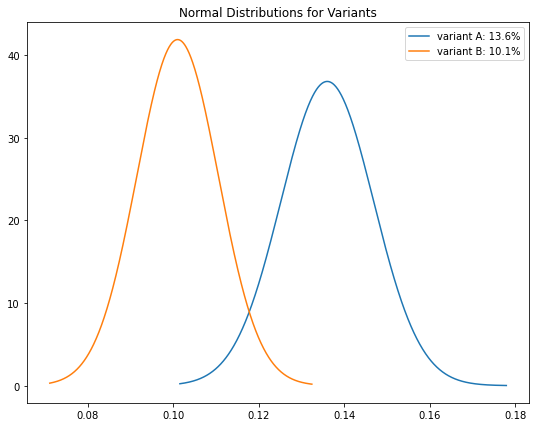

In [14]:
experiment.plot_data_distribution()

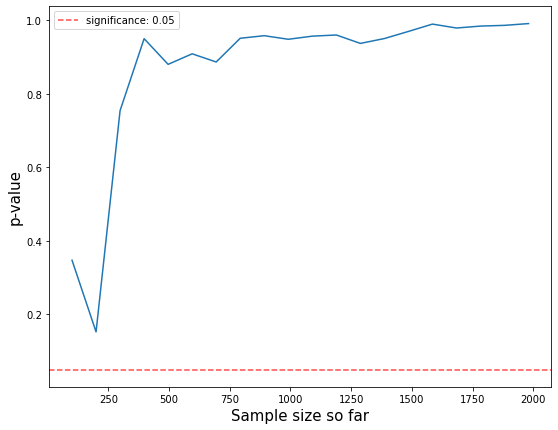

In [15]:
experiment.plot_timeline()

## Estimate Sample Sizes

some references:
- [calculator evan miller](https://www.evanmiller.org/ab-testing/sample-size.html). Looks the most reliable.
- [ab test guide (not very reliable)](https://abtestguide.com/calc/)
- [discussion in YC's Forum (advanced)](https://news.ycombinator.com/item?id=13437431)
- [Sample Sizes Required - Suny Polytechnich](https://www.itl.nist.gov/div898/handbook/prc/section2/prc222.htm) 
- [How to calculate ab testing sample size - Stack Overflow](https://stackoverflow.com/questions/28046453/how-to-calculate-ab-testing-sample-size). Here I found a book about rules of thumb that follows
- [Statistical Rules of Thumb](http://www.vanbelle.org/struts.htm) homepage. [Link to download](http://library.lol/main/3306598CAA57137F059CFC4875A4230F).
- [another calculator - CXL](https://cxl.com/ab-test-calculator/)

In [16]:
import numpy as np
from scipy.stats import norm

# evan miller's code
def evan_sample_size(dmin, p, alpha=0.05, power=0.80, effect_type='absolute'):
    """ Based on https://www.evanmiller.org/ab-testing/sample-size.html
    Params:
        alpha (float): How often are you willing to accept a Type I error (false positive)?
        power (float): How often do you want to correctly detect a true positive (1-beta)?
        p (float): Base conversion rate
        dmin (float): Minimum detectable effect
        effect_type (string): Effect type [absolute, relative]
    Return:
        sample_size (integer): Sample size per variant
    """
    if effect_type == 'absolute':
        # conver to relative
        dmin = dmin / p
    delta = p * dmin
    t_alpha2 = norm.ppf(1.0-alpha/2)
    t_beta = norm.ppf(power)
    sd1 = np.sqrt(2 * p * (1.0 - p))
    sd2 = np.sqrt(p * (1.0 - p) + (p + delta) * (1.0 - p - delta))
    sample_size = (t_alpha2 * sd1 + t_beta * sd2) * (t_alpha2 * sd1 + t_beta * sd2) / (delta * delta)
    return round(sample_size)

In [17]:
# evan miller's website home values

min_diff=0.05
mu_baseline=0.20

estimate_sample_size(min_diff=min_diff,
                     mu_baseline=mu_baseline, 
                     test_type='two-sided')

print("evan miller: ", evan_sample_size(dmin=min_diff, p=mu_baseline))

effect_type: absolute
Test type: two-sided
objective metric type: binomial
baseline mean: 20.0%
min diff absoute: 5.0%
min diff relative: 25.0%
sigma1, sigma2:  0.5656854249492381 0.5894913061275798
min_diff is 0.09 sigma1's
estimate for sample size: 1030 samples per variation.
evan miller:  1030


In [20]:
min_diff=0.05
effect_type="absolute"
mu_baseline=0.20
estimated_impressions_daily=1000

estimate_sample_size(
    min_diff=min_diff,
    effect_type=effect_type,
    mu_baseline=mu_baseline,
    test_type='two-sided',
    estimated_impressions_daily=estimated_impressions_daily
)

print("evan miller: ", evan_sample_size(dmin=min_diff, p=mu_baseline, effect_type=effect_type) )

effect_type: absolute
Test type: two-sided
objective metric type: binomial
baseline mean: 20.0%
min diff absoute: 5.0%
min diff relative: 25.0%
sigma1, sigma2:  0.5656854249492381 0.5894913061275798
min_diff is 0.09 sigma1's
estimate for sample size: 1030 samples per variation.
With 1000 impressions per day, you will need about 2.0 days or 0.29 weeks to run this A/B Test.
evan miller:  1030


### Let's define some minimum diff in the previous simulated A/B Test to check output

In [11]:
min_diff=0.01
effect_type="absolute"
mu_baseline=0.09 
estimated_impressions_daily=1000

N = estimate_sample_size(
    min_diff=min_diff,
    effect_type=effect_type,
    mu_baseline=mu_baseline,
    estimated_impressions_daily=estimated_impressions_daily
)

effect_type: absolute
Test type: one-sided
objective metric type: binomial
baseline mean: 9.0%
min diff absoute: 1.0%
min diff relative: 11.11%
sigma1, sigma2:  0.40472212689696124 0.4146082488325576
min_diff is 0.02 sigma1's
estimate for sample size: 10295 samples per variation.
With 1000 impressions per day, you will need about 11.0 days or 1.57 weeks to run this A/B Test.


In [12]:
experiment.update_minimum_sample_size(N)
experiment.update_mu_baseline(mu_baseline)

In [13]:
experiment.run()

------------------------------
Experiment finished.
------------------------------
samples in x1:  1000
samples in x2:  1000
z statistic: -1.674157974698757
p-value: 0.9529502218232185
significance: 0.05
diff in means under H0: 0
Means/Proportions:
	x1: 0.117
	x2: 0.094
	x2 - x1: -0.023 (-19.66%)

For your sample size, the detectable difference estimated is: 0.0318229928605849
You CAN NOT REJECT the null hypothesis for significance 0.05.


{'statistic': -1.674157974698757,
 'pvalue': 0.9529502218232185,
 'passed': False}

In [14]:
experiment.sample_size

10295

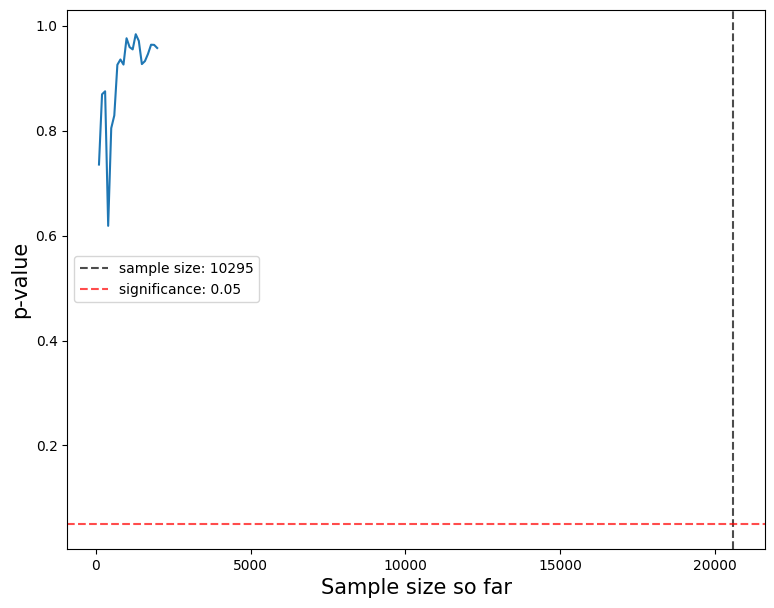

In [15]:
experiment.plot_timeline()

## plotting sample sizes for many minimum differences

In [3]:
0.13*0.03

0.0039

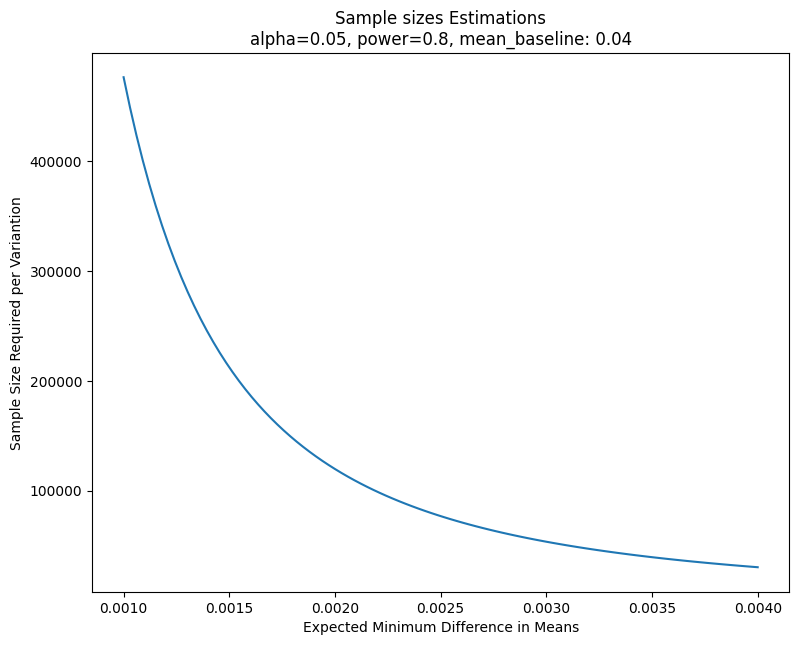

In [9]:
# min_diff=0.01
effect_type="absolute"
mu_baseline=0.04
estimated_impressions_daily=1000

min_diff_range = np.linspace(0.001, 0.004, 100)

plot_sample_sizes(
    min_diff_range=min_diff_range,
    effect_type=effect_type,
    mu_baseline=mu_baseline,
    test_type='one-sided',
    estimated_impressions_daily=estimated_impressions_daily
)